# Phase 3 Project

## 1. Business Problem and Understanding

[place holder for stakeholders & background info]

**The goal:** Create a model to predict churn in telecom members contacting support. We are aiming to reduce the amount of cases in which members are mistakenly identified as retained (false negative) vs mistakenly identified as churned to ensure we capture all members who may churn (positive).

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

In [2]:
# Load in csv

df = pd.read_csv('Data/tel_cust_curn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Data Exploration

The dataset has no missingness and most columns are numeric. Will have to explore the object type columns to assess whether to drop or transform. With 3333 entries, the dataset is not small but not the largest, depending on the distribution of the target, may need to consider re-sampling.

It looks like our columns names all have spaces where underscores should be so we will want to adjust that. We will note this in our *pre-split* steps.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
# Rename columns with '_' instead of spaces

df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

It looks like we definitely have **class imbalance** and will have to address that in our preprocessing, after splitting our train/test data.

### Target Variable: `churn`

- Of the 3,333 customers in this dataset, 483 terminated their contract with SyriaTel.
- This is an imbalanced dataset, with 14.5% of customers lost. We will need to address this before modeling in our preprocessing.
- We will also label encode this variable to change it from a bool to a numeric value.

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


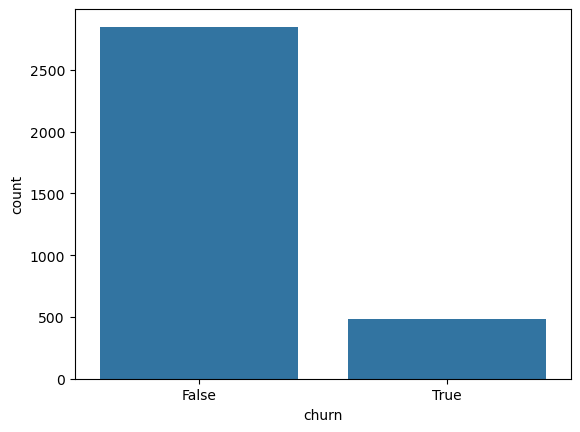

In [5]:
print(df['churn'].value_counts(normalize=True))
sns.countplot(data=df, x='churn', );

### Categorical Columns

It looks like `phone_number` is an object type, not sure we can do anything with that information as far as predictions, but we can turn it into a unique identifier for the customer. `international_plan` and `voice_main_plan` can be transformed to a binary numeric format and `state` is nominal so can be transformed to numeric as well.

In [6]:
df.select_dtypes('object')

,state,phone_number,international_plan,voice_mail_plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no
...,...,...,...,...
3328,AZ,414-4276,no,yes
3329,WV,370-3271,no,no
3330,RI,328-8230,no,no
3331,CT,364-6381,yes,no


#### `phone_number`

Since there are no duplicates, we can confidently drop the phone_number column as each row is unique.

In [7]:
print(sum(df.phone_number.value_counts().values>1))
df.drop('phone_number', axis=1, inplace=True)

0


#### `state`

This is a nominal categorical variable and can be transformed to numeric by using methods like one-hot encoding or label encoding, depending on the specific requirements of the machine learning algorithm being used. We might even consider mapping states to their respective time zones to reduce the number of variables.

In [8]:
df['state'].value_counts()

state
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: count, dtype: int64

#### `international_plan` and `voice_mail_plan`

These variables can be transformed to a binary numeric format. With no set equal to zero and yes set equal to 1. Note that there are far more customers without international and voice mail plans.

international_plan
no     0.90309
yes    0.09691
Name: proportion, dtype: float64

voice_mail_plan
no     0.723372
yes    0.276628
Name: proportion, dtype: float64


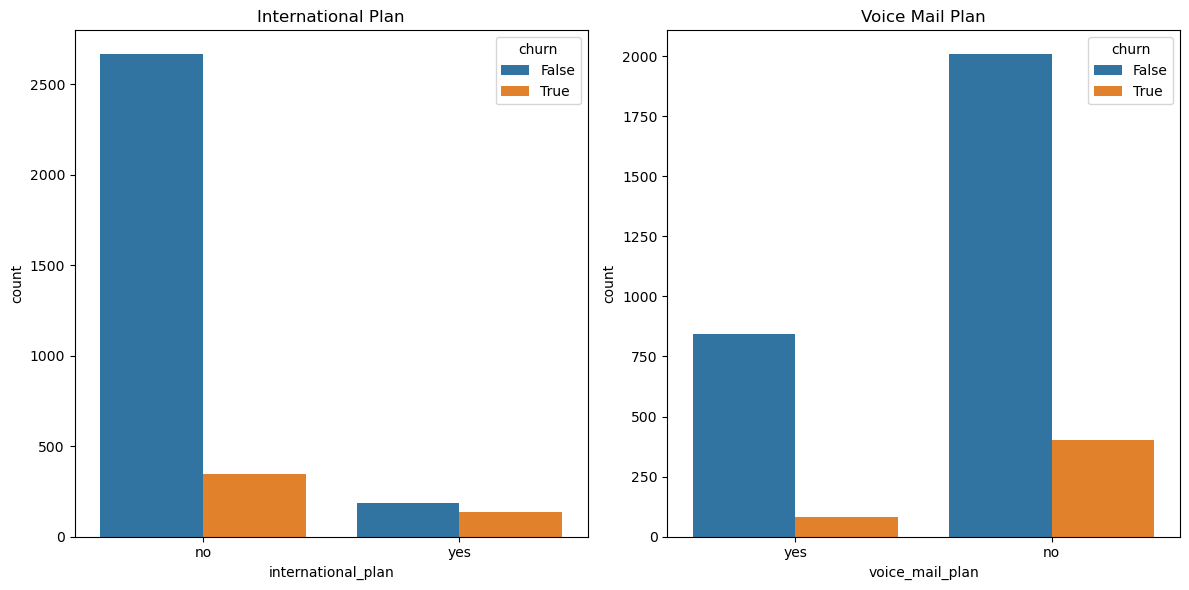

In [9]:
print(df['international_plan'].value_counts(normalize=True))
print()
print(df['voice_mail_plan'].value_counts(normalize=True))

#Histograms
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first count plot
sns.countplot(x='international_plan', hue='churn', data=df, ax=axes[0])
axes[0].set_title('International Plan')

# Plot the second count plot
sns.countplot(x='voice_mail_plan', hue='churn', data=df, ax=axes[1])
axes[1].set_title('Voice Mail Plan')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Numeric Columns

Looking at numeric datatype columns, it seems like we can consolidate certain information that seems to be telling us the same thing. Columns pertaining to minutes, calls, and charge per time of day can most likely be combined to represent each time of day by a combined metric or one of the 3 columns which best represents level of contact per time of day. This same concept can be applies to `intl` calls which it looks like represent 'international' calls.

In [10]:
df.select_dtypes('number')

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2


There seems to be very few outliers in the numeric columns. Though columns like `number_vmail_messages` and `total_day_calls` do have minimums of 0, depending on the frequency of these cases, these may need to be dropped. There is also a member who has been with the company longer than others as seen in `account_length`.

In addition, `area_code` is really a categorical variable and should be transformed after data splitting.

In [11]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## 3. Data Preperation

Before we transform columns, we will split our data into train and test sets. For our base model we will keep the train/test split as the default .75/.25 respectively. Since we know we have class imbalance, we will turn `stratify` to `True` so our class proportions stay the same for both our train and test data.

In [12]:
# Define X and y, and split train/test data
df_copy = df.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y)

### Initial Preprocessing

In [13]:
# Transform target

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('y_train')
print(y_train.value_counts(normalize=True))
print('')
print('y_test')
print(y_test.value_counts(normalize=True))

y_train
churn
0    0.855142
1    0.144858
Name: proportion, dtype: float64

y_test
churn
0    0.854916
1    0.145084
Name: proportion, dtype: float64


In [14]:
def init_processing(X):
    '''
    Initial processing, takes in train and test data.
    '''
    # transfrom y/n columns to 1/0
    X['international_plan'] = X['international_plan'].map({'yes':1,'no':0})
    X['voice_mail_plan'] = X['voice_mail_plan'].map({'yes':1,'no':0})
    # make 'state' uppercase to eliminate inconsitencies 
    X['state'] = X['state'].str.upper()
    # turn `phone_number` into int
    #X['phone_number'] = X['phone_number'].str.replace('-','').astype(int)
    return X

X_train = init_processing(X_train)
X_train

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
2965,WI,103,415,0,0,0,180.2,134,30.63,97.7,85,8.30,181.7,134,8.18,8.4,3,2.27,1
692,NE,82,408,0,0,0,185.8,36,31.59,276.5,134,23.50,192.1,104,8.64,5.7,7,1.54,4
64,NC,38,408,0,0,0,131.2,98,22.30,162.9,97,13.85,159.0,106,7.15,8.2,6,2.21,2
1005,ND,12,510,1,0,0,216.7,117,36.84,116.5,126,9.90,220.0,110,9.90,9.8,4,2.65,2
2892,DE,103,415,0,1,34,138.8,80,23.60,142.0,108,12.07,183.8,77,8.27,11.8,7,3.19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,OH,169,408,0,0,0,147.2,115,25.02,161.9,123,13.76,142.1,103,6.39,7.2,6,1.94,3
2038,TX,136,408,0,0,0,269.8,106,45.87,228.8,101,19.45,257.5,106,11.59,10.1,8,2.73,1
3300,SC,111,415,0,1,21,127.1,94,21.61,228.3,116,19.41,166.7,108,7.50,7.1,3,1.92,1
3313,ID,127,408,0,0,0,102.8,128,17.48,143.7,95,12.21,191.4,97,8.61,10.0,5,2.70,1


In [15]:
# Tranform 'state' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['state']]),columns=ohe.get_feature_names_out(['state']),index=X_train.index)
X_train.drop(columns=['state'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
2965,103,415,0,0,0,180.2,134,30.63,97.7,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
692,82,408,0,0,0,185.8,36,31.59,276.5,134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,408,0,0,0,131.2,98,22.30,162.9,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,12,510,1,0,0,216.7,117,36.84,116.5,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2892,103,415,0,1,34,138.8,80,23.60,142.0,108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,408,0,0,0,147.2,115,25.02,161.9,123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2038,136,408,0,0,0,269.8,106,45.87,228.8,101,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,415,0,1,21,127.1,94,21.61,228.3,116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3313,127,408,0,0,0,102.8,128,17.48,143.7,95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Tranform 'area_code' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['area_code']]),columns=ohe.get_feature_names_out(['area_code']),index=X_train.index)
X_train.drop(columns=['area_code'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
2965,103,0,0,0,180.2,134,30.63,97.7,85,8.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
692,82,0,0,0,185.8,36,31.59,276.5,134,23.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,0,0,0,131.2,98,22.30,162.9,97,13.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,12,1,0,0,216.7,117,36.84,116.5,126,9.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2892,103,0,1,34,138.8,80,23.60,142.0,108,12.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,0,0,0,147.2,115,25.02,161.9,123,13.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2038,136,0,0,0,269.8,106,45.87,228.8,101,19.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,0,1,21,127.1,94,21.61,228.3,116,19.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3313,127,0,0,0,102.8,128,17.48,143.7,95,12.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Analysis

To assess whether previously mentioned columns should be combined, we can look into the correlation between them. Looking at the heatmap below, while hard to read, we can clearly see that the state is not significantly correlated with any of the other features. Which means we can take a closer look at the features that may have a greater interaction. 

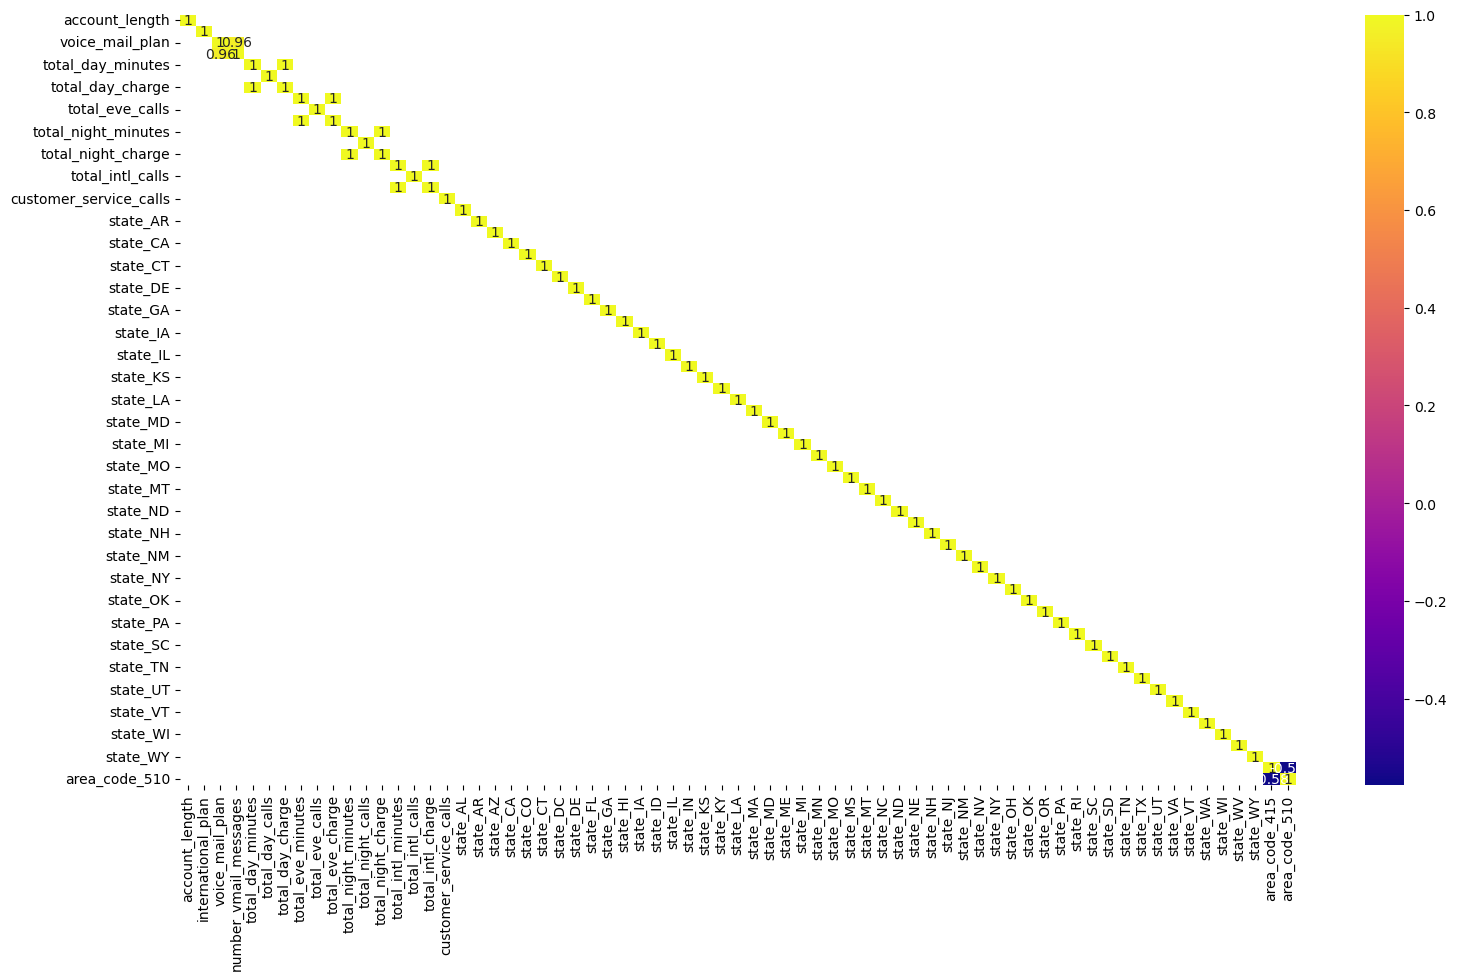

In [17]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(18,10))

corr_matrix = X_train.corr(min_periods=400)
corr_matrix = corr_matrix[corr_matrix.abs()>.1]

sns.heatmap(corr_matrix,annot=True,cmap='plasma');

We can now see clearly that charge and minutes are perfectly correlated, which makes sense if the company is charging per minute. If we need to, we can confidently drop the 'charge' column from each category; day, eve, night, and intl. We can keep the 'minutes' category as it is unclear what currency metric 'charge' is referring to.

Lastly, there is a near perfect correlation between `number_vmail_messages` and `voice_mail_plan` this makes sense and these two columns much like 'charge' and 'minutes' are telling us the same thing. If we need to, we can drop `number_vmail_messages`.

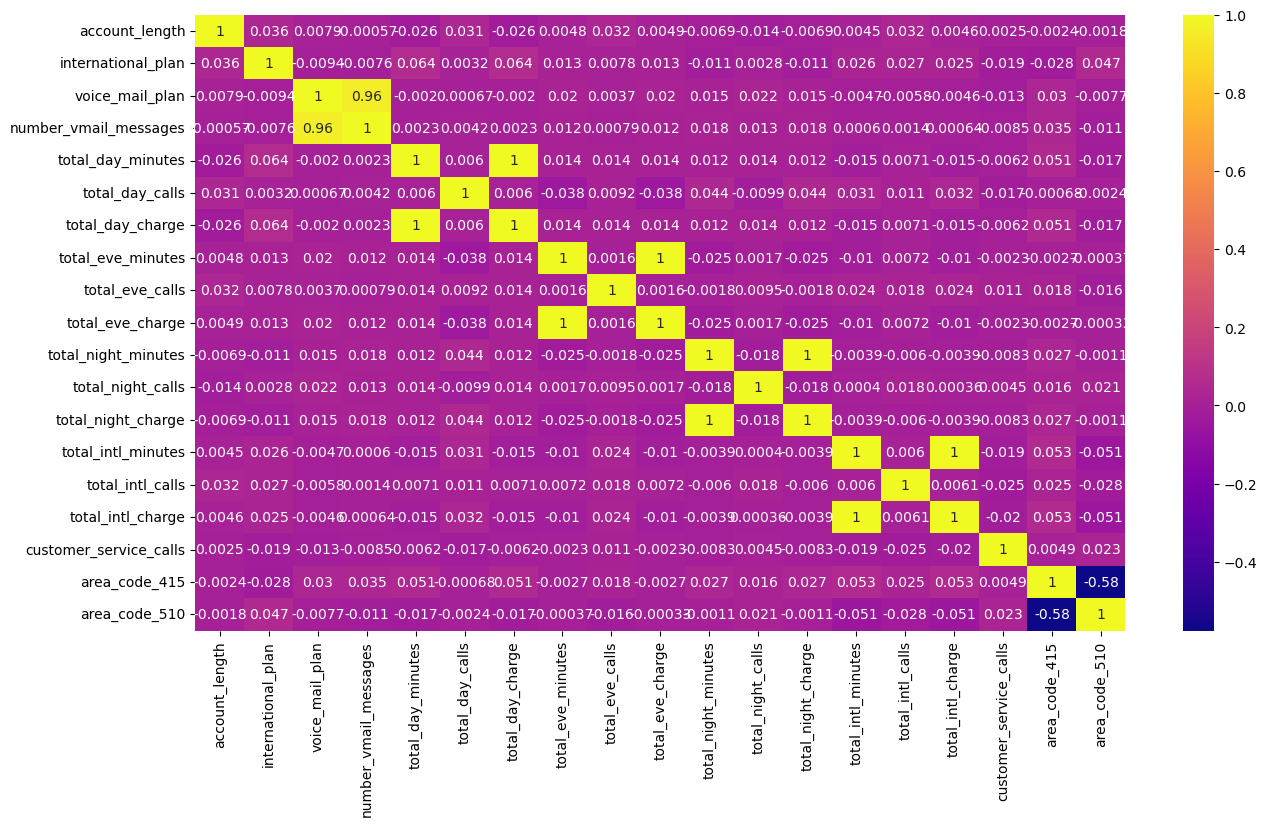

In [18]:
fig, ax = plt.subplots(figsize=(15,8))

non_state_cols = [col for col in X_train.columns if 'state' not in col]

sns.heatmap(X_train[non_state_cols].corr(min_periods=400),annot=True,cmap='plasma');

## 4. 1st Model

Give that all our features in the right format, we can build our base model with `DummyClassifier` using the `stratified` strategy since we have an imbalanced dataset skewed in the direction of class 0 when we are interested in predicting class 1.

In [19]:
base = DummyClassifier(strategy = 'stratified',random_state=42)
base.fit(X_train,y_train)

DummyClassifier(random_state=42, strategy='stratified')

### Initial `LogisticRegression` Model

To start, we will fit our data to a `LogisiticRegression` model with a `liblinear` solver so that we can potentially test both L1 and L2 penalties.

In [20]:
logreg_model = LogisticRegression(random_state=42,solver='liblinear',max_iter=200)
logreg_model.fit(X_train,y_train)

LogisticRegression(max_iter=200, random_state=42, solver='liblinear')

Comparing our first `LogisticRegression` model with our `base`, we can see that our `LogisticRegression` model does somewhat better at predicting `churn` with  92 TP results vs 57 with our `base`.

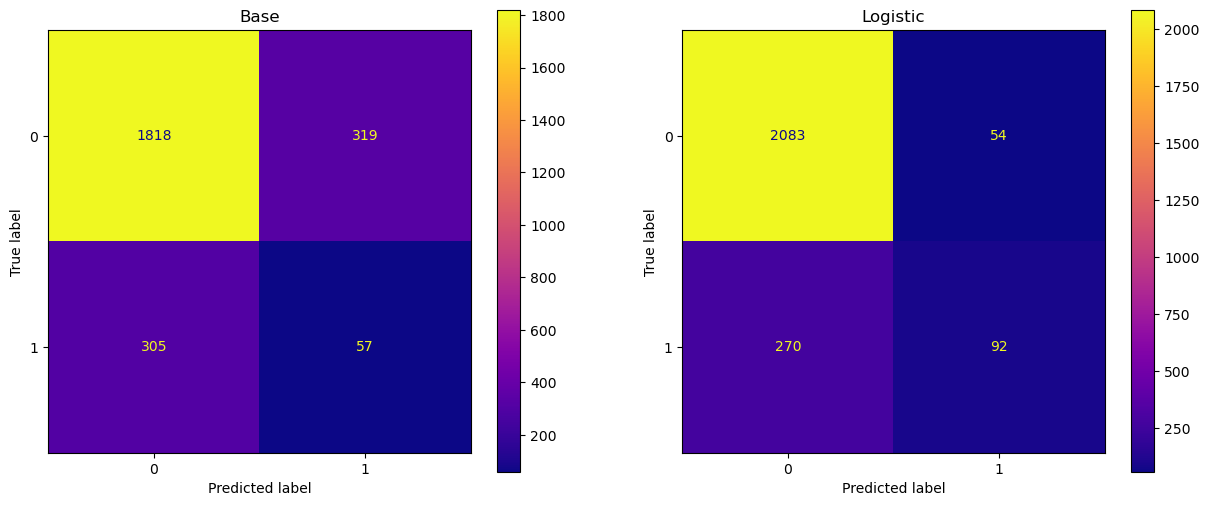

In [21]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Base')
ax[1].set_title('Logistic')

ConfusionMatrixDisplay.from_estimator(base,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[1],cmap='plasma');

Next, we can try fitting the `LogisticRegression` model with an L1 penalty.

In [22]:
logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_model_l1.fit(X_train,y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

It looks like the Logisic L1 model does better than both previous models but only slightly. However our class imbalance makes it difficult to assess accurately and needs to be addressed.

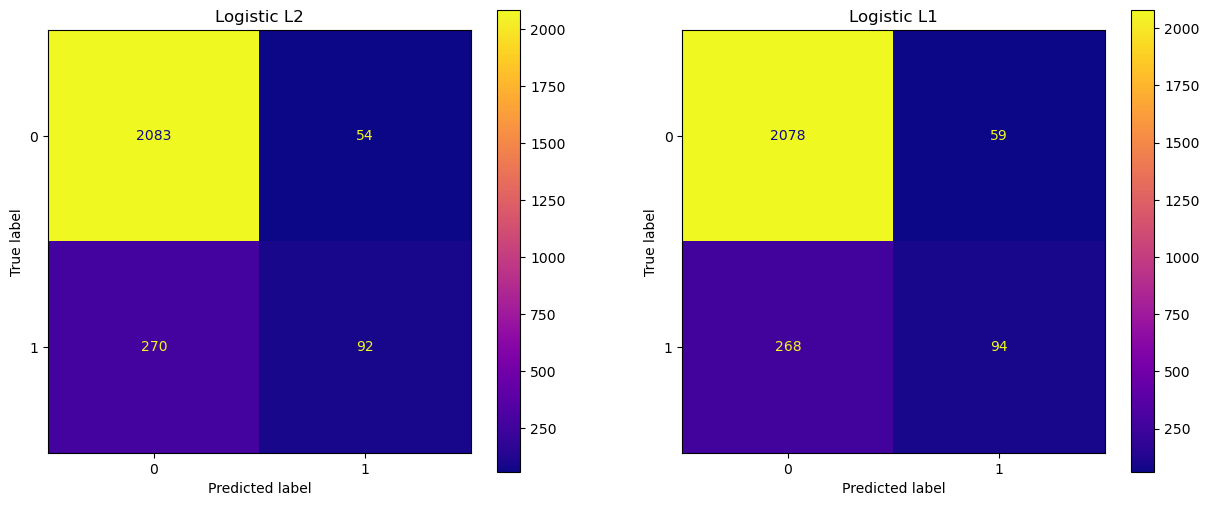

In [23]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Logistic L2')
ax[1].set_title('Logistic L1')

ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train,y_train,ax=ax[1],cmap='plasma');

### Class Imbalance with `SMOTE`

We can easily resample and even out the distribution among the classes. 

In [24]:
def Resampling(X,y):
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X,y)

    # Preview new class distribution
    print('Synthetic sample class distribution: \n')
    print(pd.Series(y_train_resampled).value_counts())
    return X_train_resampled, y_train_resampled

In [25]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

churn
0    2137
1     362
Name: count, dtype: int64
------------------------------
Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


In [26]:
ratios = [0.2, 0.4, .5, .75, 1]
names = ['0.2','0.4','0.5','0.75','even']
colors = sns.color_palette('pastel')


for n, ratio in enumerate(ratios):
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resamp_tune, y_train_resamp_tune= smote.fit_resample(X_train,y_train)
    logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=1000)
    logreg_model_l1 = logreg_model_l1.fit(X_train_resamp_tune, y_train_resamp_tune) 
    print('Synthetic Ratio: {}'.format(names[n]))

    # Cross validate
    scores = cross_val_score(logreg_model_l1,X_train_resamp_tune, y_train_resamp_tune,scoring='recall')
    print('With average recall score: {}\n'.format(scores.mean()))
    
    

Synthetic Ratio: 0.2
With average recall score: 0.25761969904240767

Synthetic Ratio: 0.4
With average recall score: 0.49650498796009634

Synthetic Ratio: 0.5
With average recall score: 0.5870343556667106

Synthetic Ratio: 0.75
With average recall score: 0.7165751557632399

Synthetic Ratio: even
With average recall score: 0.7973724528880035



0 LogisticRegression(max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.774434765479656

1 LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.774434765479656

2 LogisticRegression(max_iter=400, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.774434765479656

3 LogisticRegression(max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.774434765479656



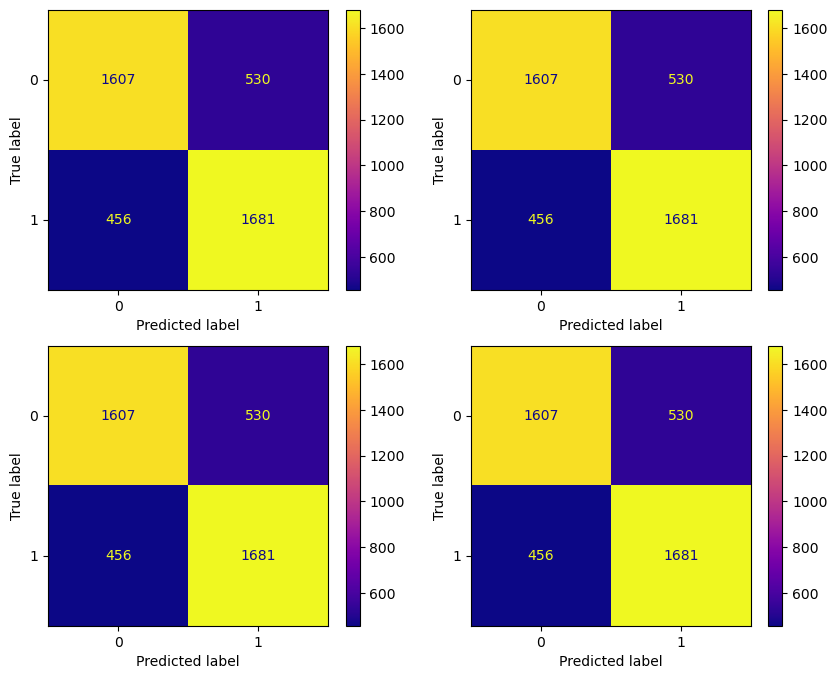

In [27]:
iterations = [200, 300, 400, 500]

ax, fig = plt.subplots(ncols=2,nrows=2,figsize=(10,8))

axes = ax.get_axes()

for i, iter in enumerate(iterations):
    logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=iter)
    logreg_model_l1 = logreg_model_l1.fit(X_train_resampled,y_train_resampled) 
    print(i, logreg_model_l1)
    print()
    scores = cross_val_score(logreg_model_l1,X_train_resampled,y_train_resampled,scoring='recall')
    print('With average recall score: {}\n'.format(scores.mean()))

    ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train_resampled,y_train_resampled,
                                          ax=axes[i],cmap='plasma')

### Model with Cross Validation

Now we have cross validated our results to finalize our 1st model with `LogisiticRegression`. We created a class to help us run Cross Validation more easily on other modles.

It looks like our model performs slightly better on the test data. We can probably get this even higher after we simplify our model some more.

In [28]:
class ModCrossVal():
    '''Create model and see the crossvalidation more easily'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
    
        # For CV results
        self.kfolds = None
        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None
    
        if cv_now:
            self.cross__val()
    
    def cross__val(self,X=None,y=None, kfolds=10):
        '''
        Perform cross validation and return results.
    
        Args:
         X:
          Optional; Training data to perform CV on. Otherwise use X from object
         y:
          Optional; Training data to perform CV on. Otherwise use y from object
         kfolds:
          Optional; Number of folds for CV (default is 8)  
        '''
    
        cv_X = X if X else self.X
        cv_y = y if y else self.y
        self.kfolds=kfolds
    
        self.cv_results = cross_validate(self.model,cv_X,cv_y,scoring='recall',return_train_score=True,cv=kfolds)
        self.cv_train_mean = np.mean(self.cv_results['train_score'])
        self.cv_test_mean = np.mean(self.cv_results['test_score'])

    def finetune_c(self):
        C_values = [0.0001, 0.001, 0.01, 0.1, 1]
    
    def cv_summary(self):
        
        summary = {
            'model_name':self.name,'kfolds':self.kfolds,'cv_train_mean':self.cv_train_mean,'cv_test_mean':self.cv_test_mean}
    
        cv_summary = pd.DataFrame(summary,columns=['model_name', 'kfolds','cv_train_mean','cv_test_mean'],
                                  index=range(1))
        return cv_summary

We can see that our train did slightly better than our test, but not too bad. We should also perform cross validation with finetune'd `C` to assess what level of penalty is best for our model.

In [29]:
mcv = ModCrossVal(logreg_model_l1, "Logistic L1", X_train_resampled, y_train_resampled)
logreg_l1_sum = mcv.cv_summary()
logreg_l1_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic L1,10,0.789061,0.779595


### Finetune `C` Parameter

After trying a few different options, we can see that a lower `C` yields better results for this model. This makes sense as we had many features we suspected were not serving the model, making higher regularization benefitial.

**Note:** to converge results in our `C` parameter tuning, we had to add a max iteration of 105.

In [30]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
l1_results = pd.DataFrame()

for c in C_values:
    logreg_l1 = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=105)
    logreg_l1.fit(X_train_resampled, y_train_resampled)
    new_results = ModCrossVal(logreg_l1, f'Logreg L1 c{c:e}', X_train_resampled, y_train_resampled)
    l1_results = pd.concat([l1_results, new_results.cv_summary()])

    l1_results

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
l1_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
l1_results

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg L1 c1.000000e-04,10,0.871572,0.871355
0,Logreg L1 c1.000000e-01,10,0.789996,0.781021
0,Logreg L1 c1.000000e+00,10,0.789061,0.779595
0,Logreg L1 c1.000000e-02,10,0.706078,0.705193
0,Logreg L1 c1.000000e-03,10,0.570946,0.570429


In [32]:
# Run optimized model

logregl1_opt = LogisticRegression(random_state=42, C=0.0001, solver='liblinear', penalty='l1')
logregl1_opt = logregl1_opt.fit(X_train_resampled,y_train_resampled)

In [33]:
# Get optimized results

mcv = ModCrossVal(logregl1_opt, "Logistic L1", X_train_resampled, y_train_resampled)
logregl1_opt_sum = mcv.cv_summary()
logregl1_opt_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic L1,10,0.871572,0.871355


## 5. 2nd Model

Since we had a few columns that were directly correlated we will try simplifying the model to see if this improves our results. 

In [34]:
X_train_reduced = X_train.drop(columns=['number_vmail_messages', 'total_day_charge', 'total_eve_charge', 
                                        'total_night_charge', 'total_intl_charge'], axis=1,)

smote = SMOTE()
X_train_resamp_reduced, y_train_resamp_reduced = smote.fit_resample(X_train_reduced,y_train)

In [35]:
# Run new reduced model with the same parameters

logreg_reduced = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_reduced = logreg_reduced.fit(X_train_resamp_reduced, y_train_resamp_reduced)
logreg_reduced

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

### Cross Validate 2nd Model

It looks like our model did slightly worse than before eliminating these columns. It would be interesting to use `SelectFromModel` to see if reducing features by weight is more appropriate.

In [36]:
mcv = ModCrossVal(logreg_reduced,'Logreg Reduced',X_train_resamp_reduced,y_train_resamp_reduced)
logreg_red_sum = mcv.cv_summary()
logreg_red_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Reduced,10,0.791868,0.778202


### Finetune `C` for 2nd Model

Finetuning our `C` for our reduced model did not impact our scores at all. This make sense if we conclude that dropping the features for this model reduced complexity and decreased the need for regularization. However, our score for this model remains less than for our previous models including our base.

Since we don't see a change in our scores, there is no need to re-run an optimized model.

In [37]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
red_results = pd.DataFrame()

for c in C_values:
    logreg_reduced = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=105)
    logreg_reduced.fit(X_train_resamp_reduced, y_train_resamp_reduced)
    new_results = ModCrossVal(logreg_l1, f'Logreg Reduced c{c:e}', X_train_resamp_reduced, y_train_resamp_reduced)
    red_results = pd.concat([red_results, new_results.cv_summary()])

    red_results

In [38]:
red_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
red_results

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Reduced c1.000000e-04,10,0.791868,0.778202
0,Logreg Reduced c1.000000e-03,10,0.791868,0.778202
0,Logreg Reduced c1.000000e-02,10,0.791868,0.778202
0,Logreg Reduced c1.000000e-01,10,0.791868,0.778202
0,Logreg Reduced c1.000000e+00,10,0.791868,0.778202


### Feature Selection with `SelectFromModel`

To evaluate which features are truly important and which are appropriate to drop, we will also use `SelectFromModel`, helping us either confirm or deny our decisions to drop manually selected features in our Logreg Reduced model above.

In [39]:
selector = SelectFromModel(logreg_model_l1)

# Using the original resampling from first SMOTE initiation
selector.fit(X_train,y_train)

SelectFromModel(estimator=LogisticRegression(max_iter=500, penalty='l1',
                                             random_state=42,
                                             solver='liblinear'))

We will use the default threshold to start and identify which features meet threshold requirements. Since we are still using our L1 Logistic model, the default threshold will be $1e^-5$.

It looks like 8 features do not meet the threshold, this is more than the amount of columns we had dropped when starting to create this 2nd model.

In [40]:
# Initate get_support 

sup = selector.get_support()

unique, counts = np.unique(sup,return_counts=True)

# Print as array to see count of features that do not meet the threshold
print(np.asarray((unique,counts)).T)

[[ 0 20]
 [ 1 49]]


In [41]:
# Create dictionary matching results with features

dict(zip(X_train.columns,selector.get_support()))

{'account_length': True,
 'international_plan': True,
 'voice_mail_plan': True,
 'number_vmail_messages': True,
 'total_day_minutes': True,
 'total_day_calls': True,
 'total_day_charge': True,
 'total_eve_minutes': True,
 'total_eve_calls': True,
 'total_eve_charge': True,
 'total_night_minutes': True,
 'total_night_calls': True,
 'total_night_charge': False,
 'total_intl_minutes': True,
 'total_intl_calls': True,
 'total_intl_charge': False,
 'customer_service_calls': True,
 'state_AL': True,
 'state_AR': False,
 'state_AZ': True,
 'state_CA': True,
 'state_CO': True,
 'state_CT': True,
 'state_DC': False,
 'state_DE': True,
 'state_FL': True,
 'state_GA': False,
 'state_HI': False,
 'state_IA': True,
 'state_ID': False,
 'state_IL': True,
 'state_IN': False,
 'state_KS': True,
 'state_KY': False,
 'state_LA': False,
 'state_MA': True,
 'state_MD': False,
 'state_ME': False,
 'state_MI': True,
 'state_MN': True,
 'state_MO': False,
 'state_MS': True,
 'state_MT': True,
 'state_NC': Fa

In [42]:
# Create function to get best features out

def select_features(X,selector):
    '''
    Given a dataframe and selector, use the selector
    to get the most important features.
    '''
    imp_feat = dict(zip(X.columns,selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,columns=[col for col in X.columns if imp_feat[col]],
                              index = X.index)
    return selected_df

In [43]:
X_train_slct = select_features(X=X_train,selector=selector)

smote = SMOTE()
X_train_resamp_slct, y_train_resamp_slct = smote.fit_resample(X_train_slct,y_train)

#### Run and Cross Validate

Now we can run our cross validation again to see how it does in comparison to the other model and it's own validation set.

In [44]:
logreg_slct = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_slct.fit(X_train_resamp_slct,y_train_resamp_slct)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

It looks like our selected feature model did better than our reduced model. It even did better than our `logreg_model_l1` model. In addition it is simplified and will run smoother, as it is less complex

In [45]:
mcv = ModCrossVal(logreg_slct,'Logistic Select', X_train_resamp_slct,y_train_resamp_slct)
logreg_sel_sum = mcv.cv_summary()
logreg_sel_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic Select,10,0.827744,0.82406


#### Finetune `C` for Logreg Select Model

Just like our Logreg L1 model, the Logreg Select model does best with smaller `C` values, this makes our manual feature selection misaligned. This model did better

In [46]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
slct_results = pd.DataFrame()

for c in C_values:
    logreg_select = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=105)
    logreg_select.fit(X_train_resamp_slct, y_train_resamp_slct)
    new_results = ModCrossVal(logreg_select, f'Logreg Select c{c:e}', X_train_resamp_slct, y_train_resamp_slct)
    slct_results = pd.concat([slct_results, new_results.cv_summary()])

    slct_results

In [47]:
slct_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
slct_results

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Select c1.000000e-04,10,0.868350,0.866206
0,Logreg Select c1.000000e+00,10,0.827744,0.824060
0,Logreg Select c1.000000e-01,10,0.812562,0.807224
0,Logreg Select c1.000000e-02,10,0.770811,0.770240
0,Logreg Select c1.000000e-03,10,0.609525,0.608299


In [48]:
# Run optimized model

logreg_slct_opt = LogisticRegression(random_state=42, C=0.0001, solver='liblinear', penalty='l1')
logreg_slct_opt = logreg_slct_opt.fit(X_train_resamp_slct,y_train_resamp_slct)

In [49]:
# Get optimized results

mcv = ModCrossVal(logreg_slct_opt, "Logistic Select", X_train_resamp_slct,y_train_resamp_slct)
logreg_slct_opt_sum = mcv.cv_summary()
logreg_slct_opt_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic Select,10,0.86835,0.866206


### Compare Logistic Models

Comparing both `recall` metrics and Confusion Matrices of all 3 models, it looks like our first Logistic Regression model is performing best after optimization of the `C` parameter.

In [50]:
results_list = [l1_results,red_results,slct_results]

def print_results():
    for res in results_list:
        print(res)
        print()

print_results()

                model_name  kfolds  cv_train_mean  cv_test_mean
0  Logreg L1 c1.000000e-04      10       0.871572      0.871355
0  Logreg L1 c1.000000e-01      10       0.789996      0.781021
0  Logreg L1 c1.000000e+00      10       0.789061      0.779595
0  Logreg L1 c1.000000e-02      10       0.706078      0.705193
0  Logreg L1 c1.000000e-03      10       0.570946      0.570429

                     model_name  kfolds  cv_train_mean  cv_test_mean
0  Logreg Reduced c1.000000e-04      10       0.791868      0.778202
0  Logreg Reduced c1.000000e-03      10       0.791868      0.778202
0  Logreg Reduced c1.000000e-02      10       0.791868      0.778202
0  Logreg Reduced c1.000000e-01      10       0.791868      0.778202
0  Logreg Reduced c1.000000e+00      10       0.791868      0.778202

                    model_name  kfolds  cv_train_mean  cv_test_mean
0  Logreg Select c1.000000e-04      10       0.868350      0.866206
0  Logreg Select c1.000000e+00      10       0.827744      0.824

In [51]:
summary_list =[logregl1_opt_sum,logreg_slct_opt_sum,logreg_red_sum]

summary_df = pd.concat(summary_list)
summary_df

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic L1,10,0.871572,0.871355
0,Logistic Select,10,0.868350,0.866206
0,Logreg Reduced,10,0.791868,0.778202


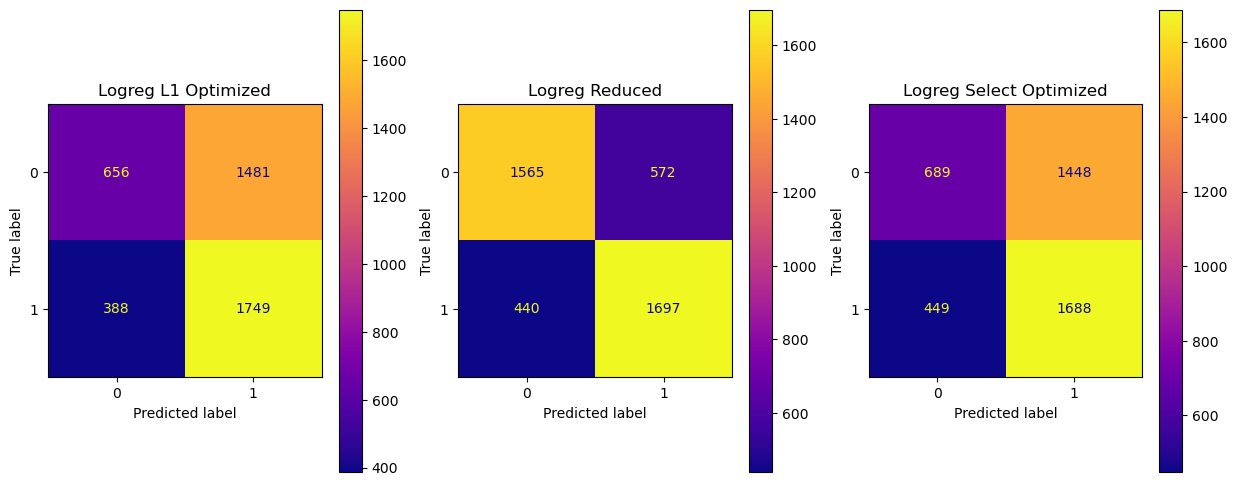

In [52]:
fig, ax = plt.subplots(ncols=3,figsize=(15,6))

ax[0].set_title('Logreg L1 Optimized')
ax[1].set_title('Logreg Reduced')
ax[2].set_title('Logreg Select Optimized')

ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_train_resampled,y_train_resampled,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_reduced,X_train_resamp_reduced,y_train_resamp_reduced,ax=ax[1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_train_resamp_slct,y_train_resamp_slct,ax=ax[2],cmap='plasma');

## 6. 3rd Model

Now we will scale our results to see if this improves our recall score.

In [53]:
# Initiate scaler

scaler = StandardScaler()
scaler.fit(X_train_resampled,scaler)

StandardScaler()

In [54]:
def scale_values(X, scaler):
    '''
    Takes DataFrame and fitted scaler as input.
    '''
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled,columns=X.columns,index=X.index)
    return X_scaled

In [55]:
X_train_scaled = scale_values(X_train_resampled,scaler)
X_train_scaled.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
0,0.043107,-0.296325,-0.487243,-0.542258,-0.200216,1.738004,-0.200661,-2.165066,-0.817901,-2.166263,...,-0.177599,-0.151267,-0.132296,-0.161714,-0.172753,7.464087,-0.181633,-0.163211,1.061209,-0.603288
1,-0.516729,-0.296325,-0.487243,-0.542258,-0.107201,-3.387581,-0.106865,1.470074,1.839732,1.469479,...,-0.177599,-0.151267,-0.132296,-0.161714,-0.172753,-0.151302,-0.181633,-0.163211,-1.095572,-0.603288
2,-1.689719,-0.296325,-0.487243,-0.542258,-1.014097,-0.144864,-1.014538,-0.839501,-0.167052,-0.838739,...,-0.177599,-0.151267,-0.132296,-0.161714,-0.172753,-0.151302,-0.181633,-0.163211,-1.095572,-0.603288
3,-2.382849,3.374671,-0.487243,-0.542258,0.406042,0.848872,0.406083,-1.782848,1.405833,-1.783553,...,-0.177599,-0.151267,-0.132296,-0.161714,-0.172753,-0.151302,-0.181633,-0.163211,-1.095572,1.906839
4,0.043107,-0.296325,2.052363,2.222806,-0.887863,-1.086298,-0.887523,-1.264414,0.429559,-1.264503,...,-0.177599,-0.151267,-0.132296,-0.161714,-0.172753,-0.151302,-0.181633,-0.163211,1.061209,-0.603288


### Run and Cross Validate

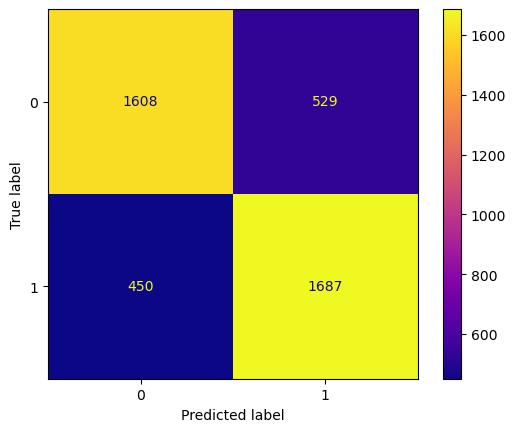

In [56]:
logreg_scaled = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_scaled.fit(X_train_scaled,y_train_resampled)

ConfusionMatrixDisplay.from_estimator(logreg_scaled,X_train_scaled,y_train_resampled,cmap='plasma');

In [57]:
mcv = ModCrossVal(logreg_slct,'Logistic Scaled', X_train_scaled,y_train_resampled)
logreg_scaled_sum = mcv.cv_summary()
logreg_scaled_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic Scaled,10,0.787085,0.774911


### Finetune `C` for 3rd Model
To compare to other models, first we will fine tune the `C` parameter.

In [58]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
scaled_results = pd.DataFrame()

for c in C_values:
    logreg_scaled = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=105)
    logreg_scaled.fit(X_train_scaled, y_train_resampled)
    new_results = ModCrossVal(logreg_l1, f'Logreg Reduced c{c:e}', X_train_scaled, y_train_resampled)
    scaled_results = pd.concat([scaled_results, new_results.cv_summary()])

    scaled_results

Since optimizing `C` has not impact, we will not run an optimized model and proceed to the comparison of the Confusion Matrices as the recall on it's own is not better than our firt Logistic model, which is so far performing best.

In [59]:
scaled_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
scaled_results

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Reduced c1.000000e-04,10,0.787085,0.774911
0,Logreg Reduced c1.000000e-03,10,0.787085,0.774911
0,Logreg Reduced c1.000000e-02,10,0.787085,0.774911
0,Logreg Reduced c1.000000e-01,10,0.787085,0.774911
0,Logreg Reduced c1.000000e+00,10,0.787085,0.774911


### Compare Confusion Matrices

While the scaled model has slightly lesser recall, looking at the matrices, it is able to capture True Positives nearly as well as our first model while better reducing false positives. 

However, since we care most about capturing True Positives and reducing False negatives, we can say it does slightly worse than our original Logistic model.

**Note:** the Scaled model does reduce false positives significantly more than our original Logisitic model, however our stakeholders may be ok with reaching out to customers who inaccurately appear to show signs of churning (False Positives) to be able to better catch those who inaccurately appear to show signs of being retained (False Negatives)

In [60]:
new_summary_list =[logregl1_opt_sum,logreg_slct_opt_sum,logreg_red_sum,logreg_scaled_sum]

summary_df = pd.concat(new_summary_list)
summary_df

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic L1,10,0.871572,0.871355
0,Logistic Select,10,0.868350,0.866206
0,Logreg Reduced,10,0.791868,0.778202
0,Logistic Scaled,10,0.787085,0.774911


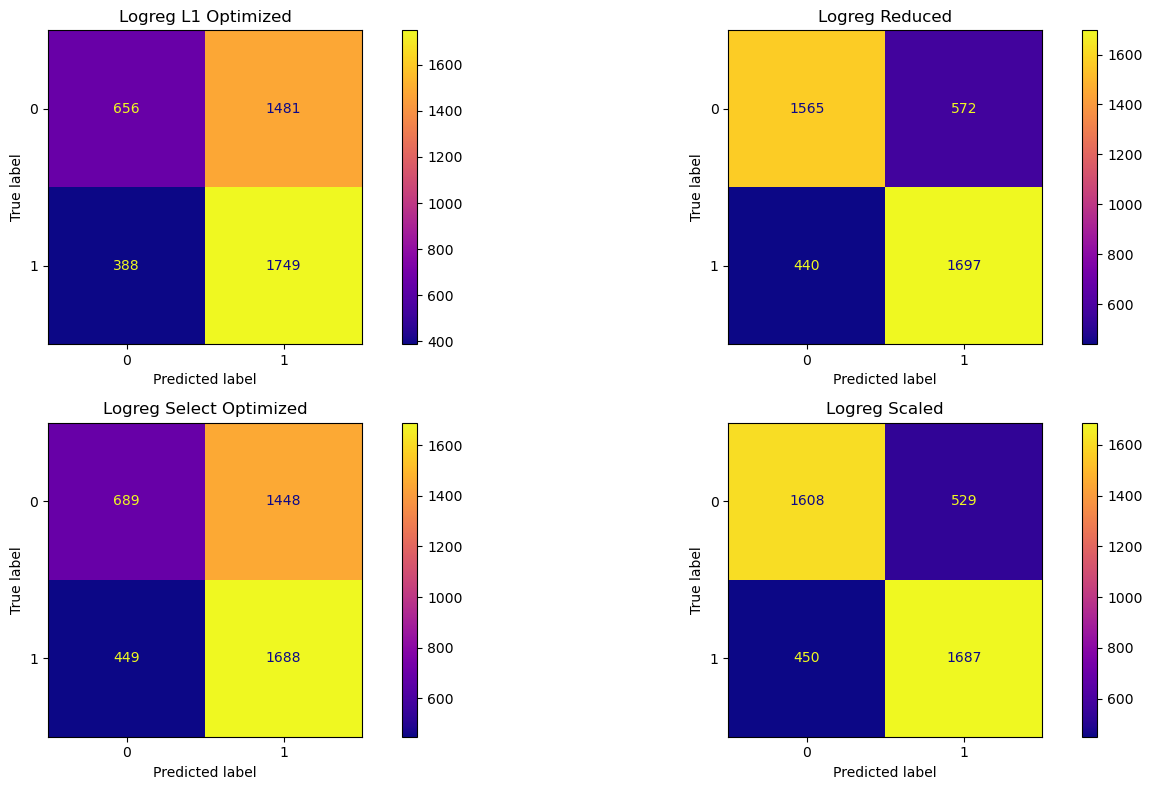

In [61]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))

ax[0,0].set_title('Logreg L1 Optimized')
ax[0,1].set_title('Logreg Reduced')
ax[1,0].set_title('Logreg Select Optimized')
ax[1,1].set_title('Logreg Scaled')

ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_train_resampled,y_train_resampled,ax=ax[0,0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_reduced,X_train_resamp_reduced,y_train_resamp_reduced,ax=ax[0,1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_train_resamp_slct,y_train_resamp_slct,ax=ax[1,0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_scaled,X_train_scaled,y_train_resampled,ax=ax[1,1],cmap='plasma')

plt.tight_layout();

## 7. 4th Model

Since exploring the data, we were curious how the model would perform if we tranformed the `state` column into timezones. For this iteration we will have to preprocess a bit differently.

### Tranform `state` to `time_zone` with `LabelEncoder`

In [62]:
# Copy X
X_tz = X.copy()

# Assuming df is your DataFrame containing the state column
state_timezone_mapping = {
    'CT': 'EST', 'DE': 'EST', 'FL': 'EST', 'GA': 'EST', 'IN': 'EST', 'KY': 'EST', 'MA': 'EST',
    'MD': 'EST', 'ME': 'EST', 'MI': 'EST', 'NC': 'EST', 'NH': 'EST', 'NJ': 'EST', 'NY': 'EST',
    'OH': 'EST', 'PA': 'EST', 'RI': 'EST', 'SC': 'EST', 'TN': 'EST', 'VA': 'EST', 'VT': 'EST',
    'WV': 'EST',
    'AL': 'CST', 'AR': 'CST', 'IA': 'CST', 'IL': 'CST', 'KS': 'CST', 'LA': 'CST', 'MN': 'CST',
    'MO': 'CST', 'MS': 'CST', 'ND': 'CST', 'NE': 'CST', 'OK': 'CST', 'SD': 'CST', 'TX': 'CST',
    'WI': 'CST',
    'CO': 'MST', 'ID': 'MST', 'MT': 'MST', 'NM': 'MST', 'UT': 'MST', 'WY': 'MST',
    'AZ': 'MST', 'NV': 'PST',
    'CA': 'PST', 'OR': 'PST', 'WA': 'PST', 'AK': 'AKST', 'HI': 'HST', 'DC': 'EST'}

# Add a new column for time zone based on the mapping
X_tz['time_zone'] = X_tz['state'].map(state_timezone_mapping)

# Group the states by time zone and calculate value counts
state_counts_by_timezone = X_tz.groupby('time_zone')['state'].value_counts()

print(state_counts_by_timezone)

time_zone  state
AKST       AK        52
CST        MN        84
           AL        80
           WI        78
           TX        72
           KS        70
           MS        65
           MO        63
           ND        62
           NE        61
           OK        61
           SD        60
           IL        58
           AR        55
           LA        51
           IA        44
EST        WV       106
           NY        83
           OH        78
           VA        77
           CT        74
           MI        73
           VT        73
           IN        71
           MD        70
           NC        68
           NJ        68
           MA        65
           RI        65
           FL        63
           ME        62
           DE        61
           SC        60
           KY        59
           NH        56
           DC        54
           GA        54
           TN        53
           PA        45
HST        HI        53
MST        WY        77

In [63]:
# Initial preprocessing

init_processing(X_tz)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,time_zone
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,CST
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,EST
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,EST
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,EST
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,CST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,MST
3329,WV,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,EST
3330,RI,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,EST
3331,CT,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,EST


In [64]:
X_tz.drop('state', axis=1, inplace=True)

### Split Train/Test and Preprocess X_train

In [65]:
# Split new data

X_train_tz, X_test_tz, y_train_tz, y_test_tz = train_test_split(X_tz,y,random_state=7,stratify=y)

In [66]:
# Tranform 'state' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train_tz[['time_zone']]),columns=ohe.get_feature_names_out(['time_zone']),index=X_train_tz.index)
X_train_tz.drop(columns=['time_zone'],axis=1,inplace=True)
X_train_tz = pd.concat([X_train_tz,ohe_df],axis=1)
X_train_tz

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,time_zone_CST,time_zone_EST,time_zone_HST,time_zone_MST,time_zone_PST
2965,103,415,0,0,0,180.2,134,30.63,97.7,85,...,8.18,8.4,3,2.27,1,1.0,0.0,0.0,0.0,0.0
692,82,408,0,0,0,185.8,36,31.59,276.5,134,...,8.64,5.7,7,1.54,4,1.0,0.0,0.0,0.0,0.0
64,38,408,0,0,0,131.2,98,22.30,162.9,97,...,7.15,8.2,6,2.21,2,0.0,1.0,0.0,0.0,0.0
1005,12,510,1,0,0,216.7,117,36.84,116.5,126,...,9.90,9.8,4,2.65,2,1.0,0.0,0.0,0.0,0.0
2892,103,415,0,1,34,138.8,80,23.60,142.0,108,...,8.27,11.8,7,3.19,1,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,408,0,0,0,147.2,115,25.02,161.9,123,...,6.39,7.2,6,1.94,3,0.0,1.0,0.0,0.0,0.0
2038,136,408,0,0,0,269.8,106,45.87,228.8,101,...,11.59,10.1,8,2.73,1,1.0,0.0,0.0,0.0,0.0
3300,111,415,0,1,21,127.1,94,21.61,228.3,116,...,7.50,7.1,3,1.92,1,0.0,1.0,0.0,0.0,0.0
3313,127,408,0,0,0,102.8,128,17.48,143.7,95,...,8.61,10.0,5,2.70,1,0.0,0.0,0.0,1.0,0.0


In [67]:
# Tranform 'area_code' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train_tz[['area_code']]),columns=ohe.get_feature_names_out(['area_code']),index=X_train_tz.index)
X_train_tz.drop(columns=['area_code'],axis=1,inplace=True)
X_train_tz = pd.concat([X_train_tz,ohe_df],axis=1)
X_train_tz

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_intl_calls,total_intl_charge,customer_service_calls,time_zone_CST,time_zone_EST,time_zone_HST,time_zone_MST,time_zone_PST,area_code_415,area_code_510
2965,103,0,0,0,180.2,134,30.63,97.7,85,8.30,...,3,2.27,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
692,82,0,0,0,185.8,36,31.59,276.5,134,23.50,...,7,1.54,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,0,0,0,131.2,98,22.30,162.9,97,13.85,...,6,2.21,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1005,12,1,0,0,216.7,117,36.84,116.5,126,9.90,...,4,2.65,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2892,103,0,1,34,138.8,80,23.60,142.0,108,12.07,...,7,3.19,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,0,0,0,147.2,115,25.02,161.9,123,13.76,...,6,1.94,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2038,136,0,0,0,269.8,106,45.87,228.8,101,19.45,...,8,2.73,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,0,1,21,127.1,94,21.61,228.3,116,19.41,...,3,1.92,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3313,127,0,0,0,102.8,128,17.48,143.7,95,12.21,...,5,2.70,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train_tz.value_counts())

smote = SMOTE()
X_train_resamp_tz, y_train_resamp_tz = smote.fit_resample(X_train_tz,y_train_tz)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

churn
False    2137
True      362
Name: count, dtype: int64
------------------------------
Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


#### Run and Cross Validate 

After running the initial model with timezones vs state, we see that the model is not performing better than our previous models. Once we use `SelectFromModel` and optimize the `C` parameter we can make a more informed comparison.

**Note:** We had to add a max iteration for the model to properly converge. But for the final optimized model we will ideally leave this out to match the other finalized models up to this point.

In [69]:
logreg_tz = LogisticRegression(random_state=42,solver='liblinear',penalty='l1', max_iter=200)
logreg_tz.fit(X_train_resamp_tz,y_train_resamp_tz)

LogisticRegression(max_iter=120, penalty='l1', random_state=42,
                   solver='liblinear')

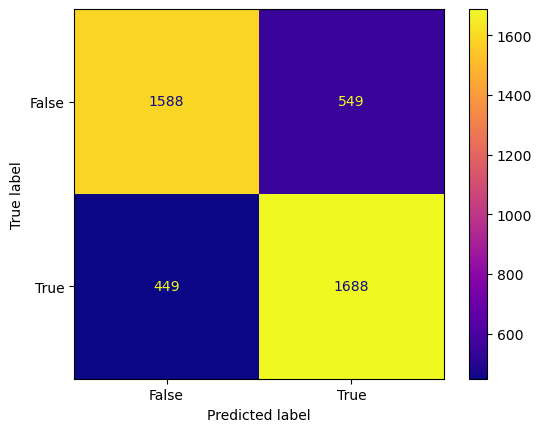

In [70]:
ConfusionMatrixDisplay.from_estimator(logreg_tz,X_train_resamp_tz,y_train_resamp_tz,cmap='plasma');

In [71]:
mcv = ModCrossVal(logreg_tz,'Logreg Timezone',X_train_resamp_tz,y_train_resamp_tz)
logreg_tz_sum = mcv.cv_summary()
logreg_tz_sum

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Timezone,10,0.789424,0.78665


### Feature Selection with `SelectFromModel`

In [72]:
# Initiate slector and fit

selector = SelectFromModel(logreg_tz)
selector.fit(X_train_resamp_tz,y_train_resamp_tz)

SelectFromModel(estimator=LogisticRegression(max_iter=120, penalty='l1',
                                             random_state=42,
                                             solver='liblinear'))

In [73]:
# Define support and create dict

sup = selector.get_support()
unique, counts = np.unique(sup,return_counts=True)
print(np.asarray((unique,counts)).T)

dict(zip(X_train_resamp_tz.columns,selector.get_support()))

[[ 0  4]
 [ 1 20]]


{'account_length': True,
 'international_plan': True,
 'voice_mail_plan': True,
 'number_vmail_messages': True,
 'total_day_minutes': True,
 'total_day_calls': True,
 'total_day_charge': True,
 'total_eve_minutes': True,
 'total_eve_calls': True,
 'total_eve_charge': False,
 'total_night_minutes': True,
 'total_night_calls': True,
 'total_night_charge': False,
 'total_intl_minutes': True,
 'total_intl_calls': True,
 'total_intl_charge': False,
 'customer_service_calls': True,
 'time_zone_CST': True,
 'time_zone_EST': True,
 'time_zone_HST': False,
 'time_zone_MST': True,
 'time_zone_PST': True,
 'area_code_415': True,
 'area_code_510': True}

In [74]:
# Extract important features

X_train_sel_tz = select_features(X=X_train_resamp_tz,selector=selector)

#### Run and Cross Validate 

Looks like this model, so far, is performing the same before and after feature selection.

In [75]:
logreg_sel_tz = logreg_sel_model = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=200)
logreg_sel_tz.fit(X_train_sel_tz,y_train_resamp_tz)

LogisticRegression(max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

In [76]:
mcv = ModCrossVal(logreg_sel_tz,'Logreg Timezone',X_train_sel_tz,y_train_resamp_tz)
logreg_sel_tz_sum = mcv.cv_summary()
logreg_sel_tz_sum

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Timezone,10,0.789528,0.78665


### Optimize `C` Parameter

In [77]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
timezone_results = pd.DataFrame()

for c in C_values:
    logreg_sel_tz = LogisticRegression(random_state=42, C=c, solver='liblinear', penalty='l1',max_iter=200)
    logreg_sel_tz.fit(X_train_sel_tz,y_train_resamp_tz)
    new_results = ModCrossVal(logreg_sel_tz, f'Logreg Timezone c{c:e}', X_train_sel_tz,y_train_resamp_tz)
    timezone_results = pd.concat([timezone_results, new_results.cv_summary()])

    timezone_results

As expected, a lower `C` works best for this model. We will finish optimizing and compare to our model list so far.

In [78]:
timezone_results.sort_values(by='cv_test_mean',ascending=False,inplace=True)
timezone_results

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logreg Timezone c1.000000e-04,10,0.871676,0.869484
0,Logreg Timezone c1.000000e+00,10,0.789528,0.786650
0,Logreg Timezone c1.000000e-01,10,0.791348,0.782917
0,Logreg Timezone c1.000000e-02,10,0.716113,0.716430
0,Logreg Timezone c1.000000e-03,10,0.590860,0.591021


#### Run and Cross Validate

In [79]:
logreg_tz_opt = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',C=0.0001)
logreg_tz_opt.fit(X_train_sel_tz,y_train_resamp_tz)

LogisticRegression(C=0.0001, penalty='l1', random_state=42, solver='liblinear')

In [80]:
mcv = ModCrossVal(logreg_tz_opt,'Logreg Timezone',X_train_sel_tz,y_train_resamp_tz)
logreg_tz_opt_sum = mcv.cv_summary()

# Add results to summary df
summary_df = pd.concat([summary_df,logreg_tz_opt_sum])

In [81]:
summary_df.sort_values(by='cv_test_mean',ascending=False,inplace=True)
summary_df

,model_name,kfolds,cv_train_mean,cv_test_mean
0,Logistic L1,10,0.871572,0.871355
0,Logreg Timezone,10,0.871676,0.869484
0,Logistic Select,10,0.868350,0.866206
0,Logreg Reduced,10,0.791868,0.778202
0,Logistic Scaled,10,0.787085,0.774911


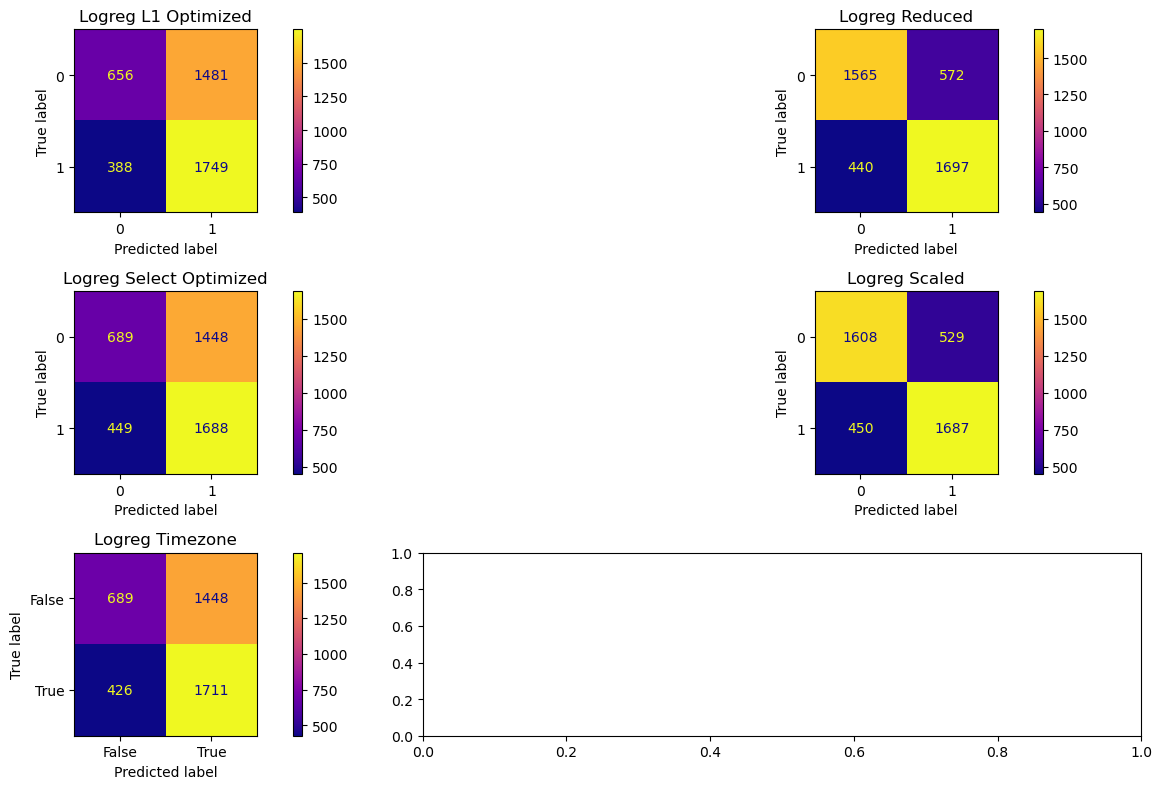

In [82]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(15,8))

ax[0,0].set_title('Logreg L1 Optimized')
ax[0,1].set_title('Logreg Reduced')
ax[1,0].set_title('Logreg Select Optimized')
ax[1,1].set_title('Logreg Scaled')
ax[2,0].set_title('Logreg Timezone')


ConfusionMatrixDisplay.from_estimator(logregl1_opt,X_train_resampled,y_train_resampled,ax=ax[0,0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_reduced,X_train_resamp_reduced,y_train_resamp_reduced,ax=ax[0,1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct_opt,X_train_resamp_slct,y_train_resamp_slct,ax=ax[1,0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_scaled,X_train_scaled,y_train_resampled,ax=ax[1,1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_tz_opt,X_train_sel_tz,y_train_resamp_tz,ax=ax[2,0],cmap='plasma')

plt.tight_layout();